Optimal Stopping Problems
===============================

> Presented by Arnav Sood (`arnav.sood@ubc.ca`).

### Introduction

We are given:

* A stochastic process ``x``, with [infinitesimal generator](https://en.wikipedia.org/wiki/Infinitesimal_generator_(stochastic_processes)) ``\mathscr{A}``.

* Flow utility ``u(x)`` and a discount rate ``\rho > 0``.

* A function ``S(x)`` which gives the value of stopping at state ``x``. The goal is to choose an optional stopping point ``\hat{x}``.

For more detail, see [here](https://github.com/econtoolkit/continuous_time_methods/blob/master/optimal_stopping.pdf).

### Classical Formulation

The "classical" formulation (see, e.g., [Stokey's book](https://press.princeton.edu/titles/8766.html)) of this problem is as a free-boundary problem:

```math
\rho v(x) &= u(x) + \mathscr{A} v(x) \\
v(\hat{x}) &= S(\hat{x}) \hspace{5 em} \\
v'(\hat{x}) &= 0
```

Crucially, equations (2) and (3) are _imposed conditions_ required for a valid solution.

These are commonly called the "value matching" and "smooth pasting" conditions, respectively.

## HJB Variational Inequality

Another approach is to write the problem as a [variational inequality](https://en.wikipedia.org/wiki/Variational_inequality).

The advantage is that the VM and SP conditions are baked into the problem.

That is:

```math
0 = \min\{\rho v(x) - u(x) - \mathscr{A} v(x), v(x) - S(x)\}
```

### Discretization

The next step is to discretize the problem to make it practicable for a computer.

The results of this process are below; for the details, see the [document](https://quantecon.github.io/SimpleDifferentialOperators.jl/dev/generated/discretized-differential-operator-derivation.pdf) in this repository.

```math
0 = \min\{\rho v - u - A v, v - S\}
```

where these quantities are now vectors of size ``n``.

### LCP Formulation

It happens that the inequality above can be written as a [linear complementarity problem](https://en.wikipedia.org/wiki/Linear_complementarity_problem).

Define:

```math
B &\equiv \rho I - A \\
z &\equiv v - S \\
q &\equiv -u + BS \\
w &\equiv Bz + q
```

where ``I`` is the ``n \times n`` identity matrix.

Substituting into (5) yields:

```math
0 = \min \{Bz + q, z\}
```

We can represent these as complementary slackness conditions:

```math
z^T (Bz + q) &= 0 \\
z &\geq 0 \\
Bz + q &\geq 0
```

Note that the first condition requires that at most one of ``z[i]`` or ``(Bz + q)[i]`` is nonzero ``\forall i \in \{1, 2, ... n\}``.

We can also express these succinctly using the complementarity constraints:

```math
0 \leq (Bz + q) \perp z \geq 0
```

If the choice of solver requires a slack variable, we can use the ``w`` defined earlier:

```math
0 \leq w \perp z \geq 0
```

### Implementation

First, we install and load necessary packages.

The key one is the [`PATHSolver.jl`](https://github.com/chkwon/PATHSolver.jl) package for complementarity problems.

This is a commercial solver due to Dirkse, Ferris, and Munson, who have generously made it [available](http://pages.cs.wisc.edu/~ferris/path.html) for open-source use.

In [1]:
using Pkg

# uncomment line below to add dependencies for local use
# pkg"add PATHSolver Plots Suppressor"
pkg"activate ../.." # activates the package

using SimpleDifferentialOperators
using PATHSolver, Plots, LinearAlgebra, Suppressor

Next, define the problem and set up our grid:

In [2]:
u(x) = x^(0.5) # flow utility
S(x) = 10. # stopping value
ρ = 0.05 # discount factor

M = 300
x = range(0., 5., length = M) # grid

0.0:0.016722408026755852:5.0

Define LCP objects, solve the problem, and inspect the solution:

  1.081120 seconds (3.40 M allocations: 172.624 MiB, 4.38% gc time)


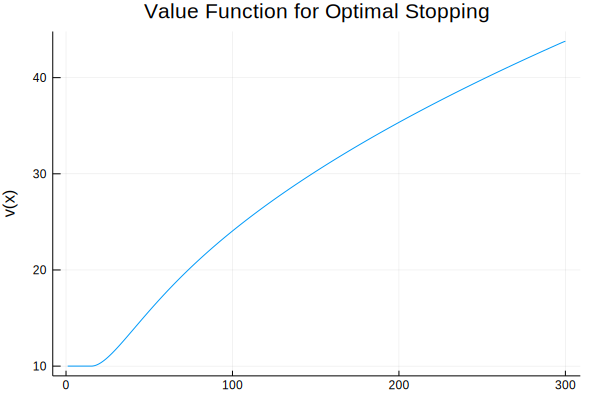

In [3]:
bc = (Reflecting(), Reflecting())
L = -0.01*L₁₋(x, bc) + (0.01^2 / 2)*L₂(x, bc) # for μ = -0.01, σ = 0.01 in the discretization PDF.

B = ρ*I - L # (eq:6)
q = -u.(x) + B*S.(x) # (eq:8)
f(z) = B*z + q # (eq:9)

lb = zeros(M)
ub = 300*ones(M)
@time code, sol, sol_f = @suppress solveLCP(f, lb, ub);

v = sol + S.(x)
plot(v, title = "Value Function for Optimal Stopping", legend = false, ylabel = "v(x)")

### References

* Huang, J. and J.-S. Pang (1998): "Option Pricing and Linear Complementarity," Journal of Computational Finance. Citeseer.

* Ben Moll's [excellent notes](http://www.princeton.edu/~moll/HACTproject/option_simple.pdf).